# SNN Input Data: From spatial information to spike stream

We aim to develop a Spiking Neural Network (SNN) capable of detecting particle tracks within the CMS detector. To achieve this, we intend to transform the spatial information provided by the detector into a spike stream suitable for input to the SNN. This notebook will delve into one method for achieving this goal.

## Libraries Needed
- `uproot` for reading ROOT files
- `numpy` for array manipulation
- `matplotlib` for plotting
- `numba` for speeding up array manipulation
- `iteration_utilities` for flatten np array after numba


## Read events fro ROOT

In [843]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt

# Plotting style
plt.style.use('seaborn-v0_8-paper')
plt.rcParams["patch.force_edgecolor"] = True

Here we will use the `uproot` library to read the ROOT file. The `uproot` library is a pythonic interface to ROOT files using Numpy and Python objects. It is a very useful library for reading ROOT files in python. You can find more information about it [here](https://uproot.readthedocs.io/en/latest/).

In [844]:
file = up.open("100k_100br.root")

dataset_all_IT = file['clusterValidIT']['tree'].arrays(library = 'np')
dataset_all_OT = file['clusterValidOT']['tree'].arrays(library = 'np')



In the root file we have internal and external tracker, we merge them together to have a single array of hits. (not important)

In [845]:
#merge IT and OT
dataset_all = {}
for key in dataset_all_IT.keys():
    dataset_all[key] = dataset_all_IT[key]
for key in dataset_all_OT.keys():
    dataset_all[key] = dataset_all_OT[key]

## Understanding the data
The data we have is a ROOT file that contains the hits in the detector. The hits are stored in a TTree with different branches. The branches are:
- `event` : the event number
- `cluster_x` : the x coordinate of the hit
- `cluster_y` : the y coordinate of the hit
- `cluster_z` : the z coordinate of the hit
- `cluster_phi` : the phi coordinate of the cluster
- `cluster_eta` : the eta coordinate of the cluster
- `eventID` : the ID of the event (BKG + Signal)
- `cluster_type` : the type of the cluster (BKG or Signal)
- `pclass`: the particle class (-1 is BKG)

Let's plot histograms to understand the data better.

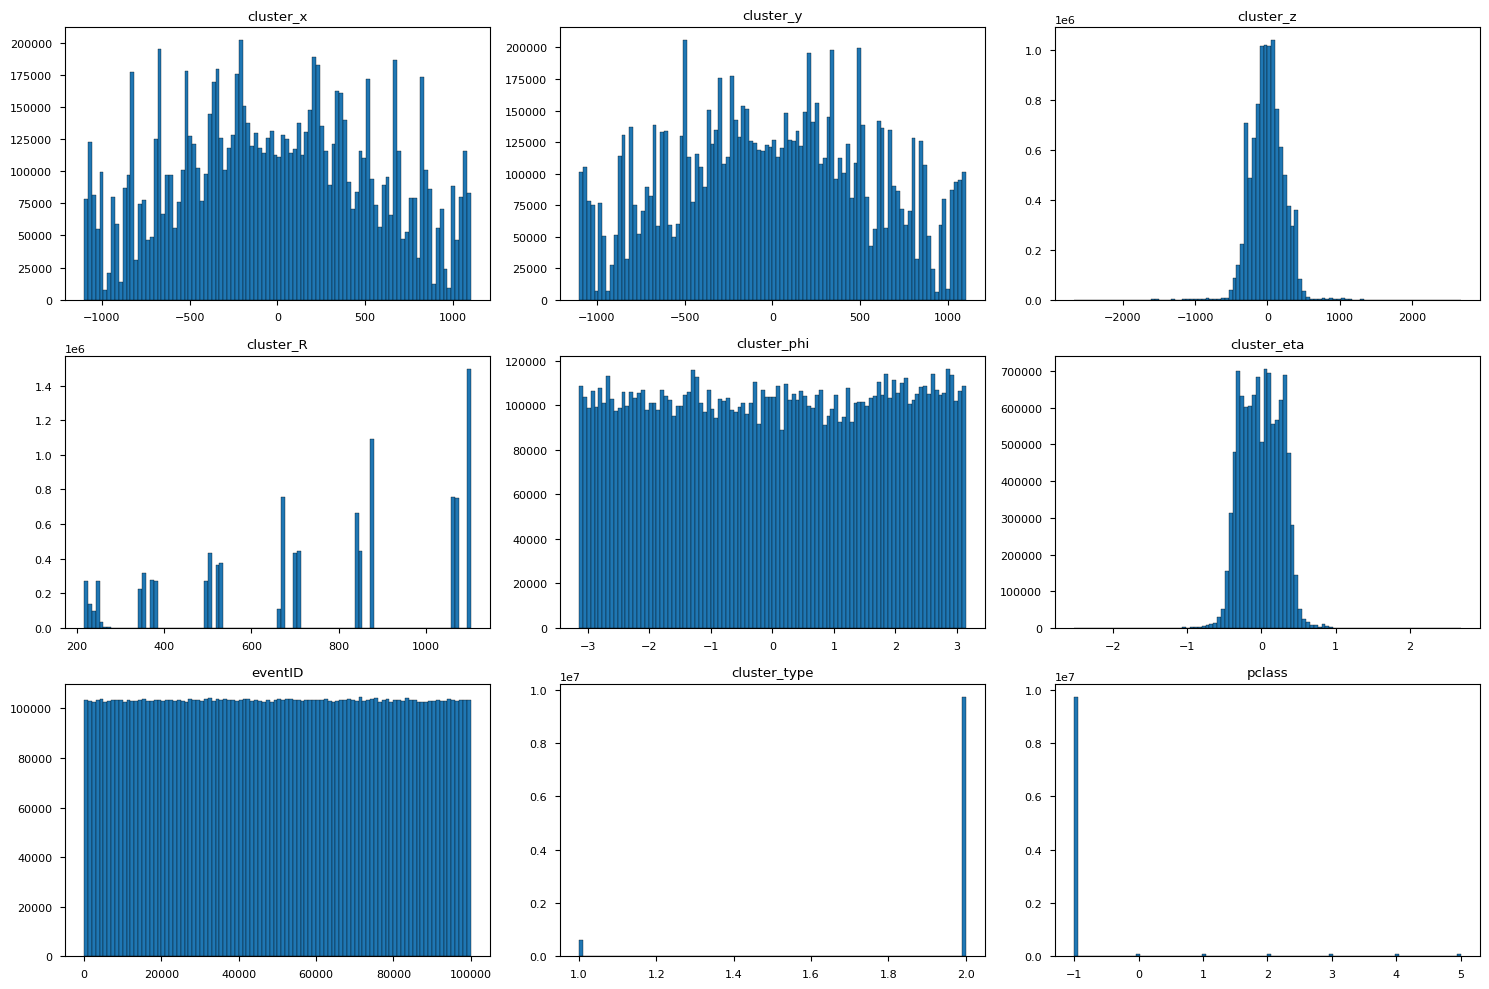

In [846]:
# plot  hiltograms
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()
for i, key in enumerate(dataset_all.keys()):
    axes[i].hist(dataset_all[key], bins=100)
    axes[i].set_title(key)
plt.tight_layout()
plt.show()



## Focus on One Single Event
Let's focus on a single event.

In [847]:
event = dataset_all['eventID'] == 2 #Event Selected

event_track = dataset_all['cluster_type'] == 1
event_bkg = dataset_all['cluster_type'] == 2

As mentioned earlier, an event consists of a set of detector hits, each with a specific position within the detector. These positions are defined by their x, y, and z coordinates.

The x and y coordinates correspond to positions in the transverse plane of the detector. Instead of using x and y, we will utilize phi and R as alternative representations.

Despite the inherently 3D nature of an event, we can plot it in a 2D format by employing the phi and R coordinates. The phi coordinate denotes the angle between a hit and the x-axis, while the R coordinate signifies the distance between a hit and the origin point of the detector

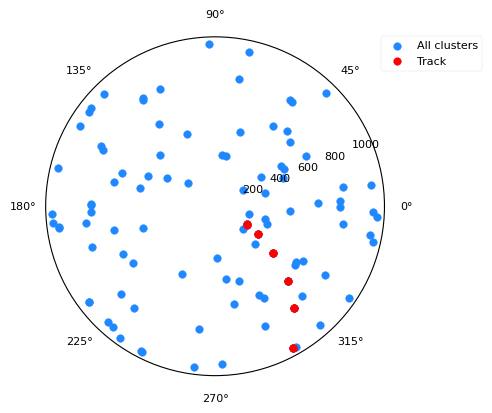

In [848]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(dataset_all['cluster_phi'][event],dataset_all['cluster_R'][event], color = '#1F88FF', label = 'All clusters')
ax.scatter(dataset_all['cluster_phi'][event & event_track],dataset_all['cluster_R'][event & event_track], color = 'red',label = 'Track')
ax.grid(False)
ax.legend(loc = (0.99,0.9))
plt.show()

To visualize the entire event, using also the `cluster_z` coordinate, we can plot different 2D plots, as the last one, projecting the hits on different planes, at different z values.

We will use 10 different z intervals for the porpoise of the plot below.

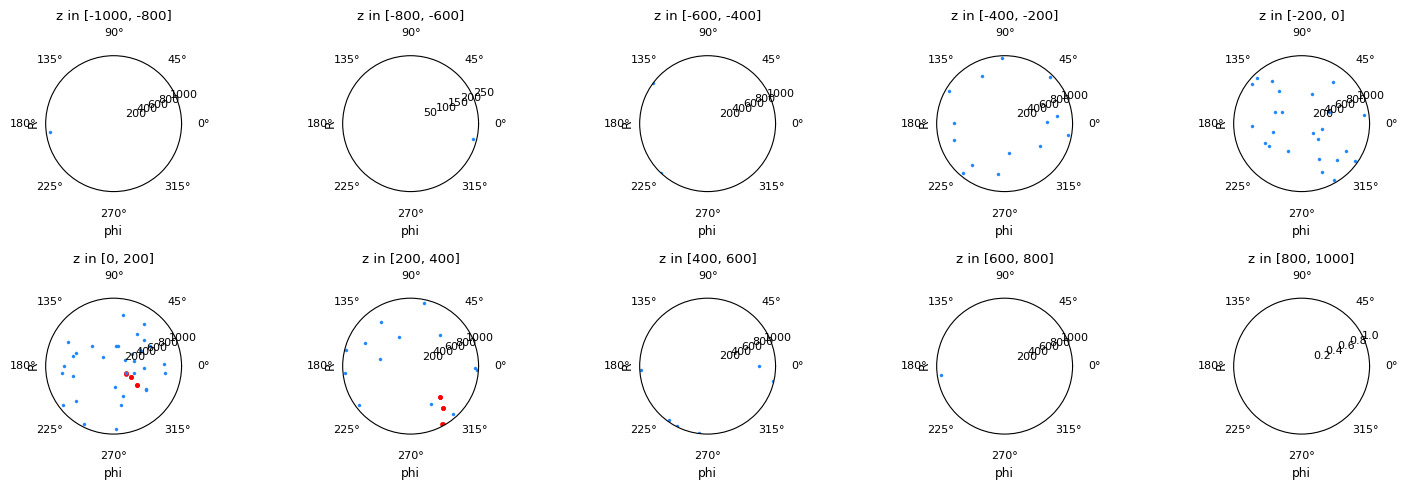

In [849]:
#plot 10 projection in 10 different bin of z, using polar coordinate and cluster_phi and cluster_R
fig, axes = plt.subplots(2, 5, figsize=(15, 5), subplot_kw={'projection': 'polar'})
axes = axes.flatten()

for i in range(10):
    axes[i].scatter(dataset_all['cluster_phi'][event & event_track & (dataset_all['cluster_z'] > i*200-1000) & (dataset_all['cluster_z'] < (i+1)*200-1000)], dataset_all['cluster_R'][event & event_track & (dataset_all['cluster_z'] > i*200-1000) & (dataset_all['cluster_z'] < (i+1)*200-1000)], s=10, color='r')
    #bkg
    axes[i].scatter(dataset_all['cluster_phi'][event & event_bkg & (dataset_all['cluster_z'] > i*200-1000) & (dataset_all['cluster_z'] < (i+1)*200-1000)], dataset_all['cluster_R'][event & event_bkg & (dataset_all['cluster_z'] > i*200-1000) & (dataset_all['cluster_z'] < (i+1)*200-1000)], s=5, color='#1F88FF')
    axes[i].set_xlabel('phi')
    axes[i].set_ylabel('R')
    axes[i].set_title('z in [{}, {}]'.format(i*200-1000, (i+1)*200-1000))
    axes[i].grid(False)
    # Remove radial and angular axis labels
plt.tight_layout()
plt.show()




As we can see, the event number `2` has a track that is clearly divided in 2 different projections, at z $\in$ [0, 200] and z $\in$ [200, 400]. 

To encode the spatial information of the event into a spike stream, we will use this concept of z intervals to encode the event into a spike stream.

We will scan each projection of the event at different z intervals and we will encode the hits in each interval into a spike stream, using a frequency and an angolar velocity.
As the scan goes on, starting from $\theta = 0$ to $\theta = 2\pi$, for a fixed value of z (that is an interval), we will associate at each hit a time value.

Also the R coordinate will be divided into intervals.

## Encode function

In [850]:
N_bin_r = 50;
N_bin_z = 50


max_R = 1200
z_range = 1200

largenumber = 999999999.
epsilon = 1. / largenumber



delta = 0.7;                    # max delta for 1Gev il 0.66rad
max_angle = 2.0 * np.pi + delta;

frequency = 40e6;               # CMS tracker reading frequency [Hz]
omega = max_angle * frequency; 


N_InputStreams = (N_bin_r)*N_bin_z
z_bin_length = z_range / N_bin_z   
r_bin_length = max_R / N_bin_r     

In [851]:

def get_bin_r(r_hit):
    if r_hit < 0:
        r_hit = 0
    if r_hit > max_R:
        r_hit = max_R - epsilon

    return int(r_hit / r_bin_length)

def get_bin_z(z):
    tmp = z + z_range / 2
    if tmp < 0:
        tmp = 0
    elif tmp > z_range:
        tmp = z_range - epsilon

    return int(tmp / z_bin_length)

def get_stream_id(r, z):
    return r + z * N_bin_r  # Vilually streams are sorted by z and then by r
    # return r * N_bin_z + z  # Uncomment for vilually sorting by r and then by z

In [852]:
from numba import prange

# @njit(parallel = True)
def create_streams_handle(phis, rs, zs, ids, event_ids):

    n = phis.shape[0] - 1

    pre_spike_time = n*[np.zeros(0)]
    pre_spike_stream =  n*[np.zeros(0)]
    pre_spike_signal =  n*[np.zeros(0)]

    for ev in prange(1,np.unique(event_ids).shape[0]):

        # Calcola il numero di elementi nel dataset
        num_elements = phis[event_ids == ev].shape[0]

        # Ordina il dataset in base all'angolo phi
        sorted_indices = np.argsort(phis[event_ids == ev])
        phi_s = phis[event_ids == ev][sorted_indices]
        r_s = rs[event_ids == ev][sorted_indices]
        z_s = zs[event_ids == ev][sorted_indices]
        id_s = ids[event_ids == ev][sorted_indices]
        # event_ids = event_ids[event_ids == ev][sorted_indices]

        for i in prange(num_elements):
            phi = phi_s[i]
            r = r_s[i]
            z = z_s[i]
            signal_id = id_s[i]

            time = (ev * (max_angle) / omega) + phi / omega
            itl = get_bin_r(r) + get_bin_z(z) * N_bin_r

            pre_spike_time[i] = np.append(pre_spike_time[i], time)
            pre_spike_stream[i] = np.append(pre_spike_stream[i], itl)
            pre_spike_signal[i] = np.append(pre_spike_signal[i], signal_id - 1)  # 0, 1, 2 -> -1, 0, 1 rispettivamente NoHit, Background, Signal

        for i in prange(num_elements):
            # Scan again from [0, delta]
            if phi > delta:
                break
            time = (ev * (max_angle) / omega) + (phi + 2 * math.pi) / omega
            itl = get_bin_r(r) + get_bin_z(z) * N_bin_r

            pre_spike_time[i] = np.append(pre_spike_time[i], time)
            pre_spike_stream[i] = np.append(pre_spike_stream[i], itl)
            pre_spike_signal[i] = np.append(pre_spike_signal[i], signal_id - 1)  # 0, 1, 2 -> -1, 0, 1 rispettivamente NoHit, Background, Signal

    return pre_spike_time, pre_spike_stream, pre_spike_signal

from iteration_utilities import deepflatten

# Flatten
def create_features(phis, rs, zs, ids, event_ids):
    res = create_streams_handle(phis, rs, zs, ids, event_ids)
    out = []
    for vec in res:
        out.append(np.asarray(list(deepflatten(vec))))  
    return out

Here you can select how many events you want to process

In [853]:
N_EVENTS = 900

In [854]:
dataset = {}
for key in dataset_all.keys():
    dataset[key] = dataset_all[key][dataset_all['eventID'] < N_EVENTS]




In [855]:
pre_spike_time, pre_spike_stream, pre_spike_signal = create_features(dataset['cluster_phi'],
                                                                     dataset['cluster_R'],
                                                                     dataset['cluster_z'],
                                                                     dataset['cluster_type'],
                                                                     dataset['eventID'])

## Plot the encoded event

In [856]:
pre_spike_time = pre_spike_time - pre_spike_time.min()

In this plot we can see encoded events.

-> Here you can select the events you want to plot

In [857]:
#set limit in order to see N events
first_event_to_show = 300
last_event_to_show = 350

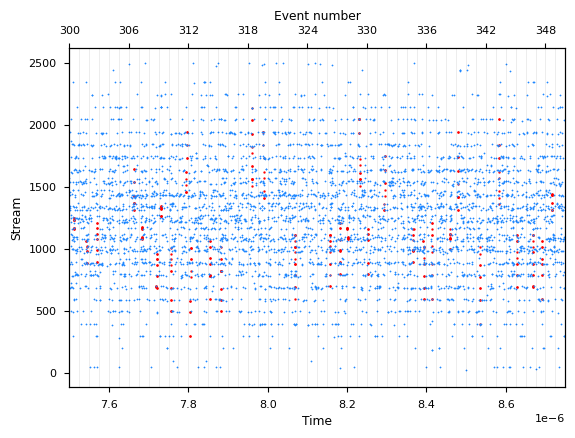

In [858]:
#plot scatter plot using spike vectors with time as x axis
fig, ax = plt.subplots()
ax.scatter(pre_spike_time[pre_spike_signal==0], pre_spike_stream[pre_spike_signal==0], s=1.9, color = 'red')
ax.scatter(pre_spike_time[pre_spike_signal==1], pre_spike_stream[pre_spike_signal==1], s=0.9, color = '#1F88FF')


for i in range(1,N_EVENTS):
    ax.axvline(x = i * (max_angle) / omega, color = 'black',alpha =0.1, linewidth = 0.5)


x_min = first_event_to_show * (max_angle) / omega
x_max = last_event_to_show * (max_angle) / omega
ax.set_xlim(x_min, x_max)

ax.set_xlabel('Time')
ax.set_ylabel('Stream')

#add second axes below the first one, in order to show the event number
ax2 = ax.twiny()
ax2.set_xlim(first_event_to_show, last_event_to_show)
ax2.set_xticks(np.arange(first_event_to_show, last_event_to_show, int((last_event_to_show-first_event_to_show)/8)))
ax2.set_xticklabels(np.arange(first_event_to_show, last_event_to_show, int((last_event_to_show-first_event_to_show)/8)))
ax2.set_xlabel('Event number')
ax2.grid(False)



plt.show()
